# Darks Souls II Reviews (2023)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

## Steam Reviews as of 12/18/23:

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews.head()

,Unnamed: 0,SteamId,Review,Recommended?,DatePosted
0,0,Xilirite,TL;DR\nBuy it if you prefer the individual lev...,Recommended,"Posted: June 2, 2017"
1,1,76561197996536125,Elden Ring waiting room,Recommended,"Posted: June 20, 2021"
2,2,76561198143997912,I thought this was supposed to be the bad one,Recommended,Posted: August 12
3,3,76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,Posted: July 4
4,4,76561198960403801,port bloodborne to pc,Recommended,"Posted: April 30, 2022"


## Data Cleaning/Wrangling:

In [3]:
reviews.drop(columns={'Unnamed: 0'}, inplace=True)
reviews.set_index('SteamId', inplace=True)
reviews.head()

,Review,Recommended?,DatePosted
SteamId,,,
Xilirite,TL;DR\nBuy it if you prefer the individual lev...,Recommended,"Posted: June 2, 2017"
76561197996536125,Elden Ring waiting room,Recommended,"Posted: June 20, 2021"
76561198143997912,I thought this was supposed to be the bad one,Recommended,Posted: August 12
76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,Posted: July 4
76561198960403801,port bloodborne to pc,Recommended,"Posted: April 30, 2022"


Just getting the dates in DatePosted:

In [4]:
dates = [re.compile(r'Posted:|,').sub(' ', date).strip() for date in reviews.DatePosted]
dates = [re.compile(r' +').sub(' ', date).strip() for date in dates]
reviews.DatePosted = dates
reviews[['DatePosted']].head()

,DatePosted
SteamId,
Xilirite,June 2 2017
76561197996536125,June 20 2021
76561198143997912,August 12
76561198088449870,July 4
76561198960403801,April 30 2022


Seperating the 'DatePosted' column into month and year columns:
- There are some entries that don't have years (will investigate later)

In [5]:
reviews['Date'] = pd.to_datetime(reviews.DatePosted, errors='coerce')
reviews['Year'] = reviews['Date'].dt.strftime('%Y')
reviews.drop(columns={'DatePosted', 'Date'}, inplace=True)
reviews

,Review,Recommended?,Year
SteamId,,,
Xilirite,TL;DR\nBuy it if you prefer the individual lev...,Recommended,2017
76561197996536125,Elden Ring waiting room,Recommended,2021
76561198143997912,I thought this was supposed to be the bad one,Recommended,NaN
76561198088449870,Little known fact: it's called dark souls 2 be...,Recommended,NaN
76561198960403801,port bloodborne to pc,Recommended,2022
...,...,...,...
Bioblade_64,The black sheep of the franchise. Still worth ...,Recommended,NaN
76561198850656966,has made me the most stressed out of the souls...,Recommended,NaN
KENOTlol,i dont like this one,Not Recommended,NaN


In [6]:
reviews.Year.isna().sum()

2179

Cleaning up the reviews:
- Replace escape sequences w/ whitespace
- Get rid of multiple spaces and trailing spaces
- Get rid of URLS (ex: https://...)
- Turn everything lowercase
- There are some reviews that are blank - will investigate later

In [7]:
r = [re.sub(r'https:\S+', ' ', review).lower().strip() if pd.notna(review) else review for review in reviews.Review]
r = [re.sub(r'[^A-Za-z0-9]', ' ', review).strip() if pd.notna(review) else review for review in r]
r = [re.sub(r' +', ' ', review).strip() if pd.notna(review) else review for review in r]
reviews.Review = r
reviews

,Review,Recommended?,Year
SteamId,,,
Xilirite,tl dr buy it if you prefer the individual leve...,Recommended,2017
76561197996536125,elden ring waiting room,Recommended,2021
76561198143997912,i thought this was supposed to be the bad one,Recommended,NaN
76561198088449870,little known fact it s called dark souls 2 bec...,Recommended,NaN
76561198960403801,port bloodborne to pc,Recommended,2022
...,...,...,...
Bioblade_64,the black sheep of the franchise still worth a...,Recommended,NaN
76561198850656966,has made me the most stressed out of the souls...,Recommended,NaN
KENOTlol,i dont like this one,Not Recommended,NaN


In [8]:
reviews.dtypes

Review          object
Recommended?    object
Year            object
dtype: object

## EDA:

Distribution of whether or not people recommend buying the game:

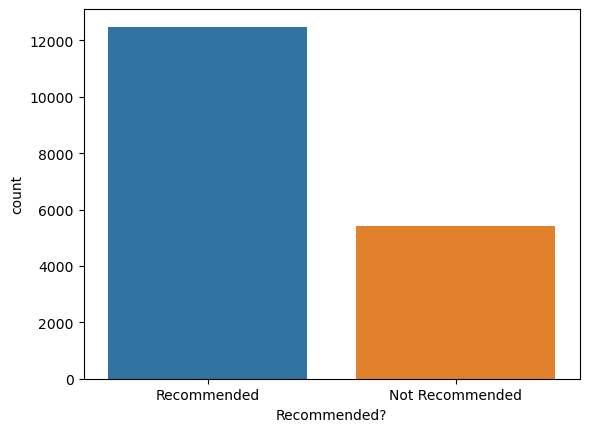

In [9]:
sns.barplot(data=reviews['Recommended?'].value_counts().reset_index(), 
            x='Recommended?',
            y='count');

- Most people recommend playing DS2

Years captured in the webscraped reviews:

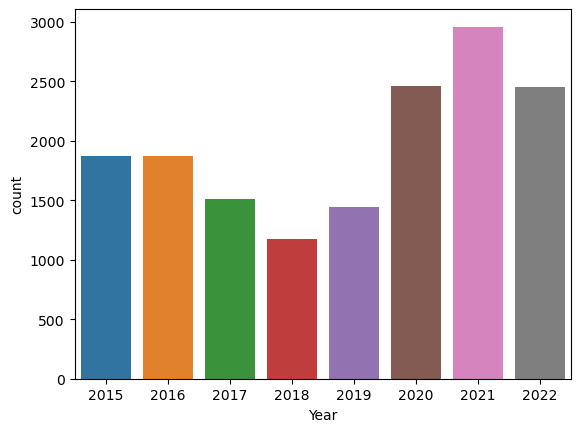

In [10]:
yr_dist = reviews.groupby('Year')['Recommended?'].count().reset_index()
yr_dist.rename(columns={'Recommended?':'count'}, inplace=True)

sns.barplot(data=yr_dist, 
            x='Year',
            y='count');

- Reviews are fairly recent
    - Game released   : March 2014
    - Remaster release: April 2015 (focus of this project)

## Sentiment Analysis:
- Needed to determine whether or not a review was postive or negaive about the game

In [11]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Spliting the reviews by how many do and don't recommend buying the game:

In [12]:
pos_reviews = reviews[reviews['Recommended?'] == 'Recommended']
neg_reviews = reviews[reviews['Recommended?'] == 'Not Recommended']

In [13]:
pos_reviews.shape, neg_reviews.shape

((12485, 3), (5415, 3))

### Exploring why people like the game:

In [14]:
tfidf = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word',
    max_features=2000,
    tokenizer=word_tokenize,
    stop_words=stopwords.words("english")
)

### Exploring why people don't like the game:

## Conclusion:

If there was one word to descibe all these reviews:

In [15]:
from wordcloud import WordCloud

In [16]:
# reviews